# VGGNet

input: 224 x 224

전처리: 각 이미지의 픽셀에서 평균 RGB 값을 빼주어 정규화를 시켜줌

2가지 종류의 커널들만 사용함
- 3 x 3: 상하좌우의 인접한 픽셀들을 인식하기 위한 최소 크기의 커널
- 1 x 1: 입력 채널에 대한 선형 변환으로 해석될 수 있음(stride: 1)

활설함수로 ReLU사용

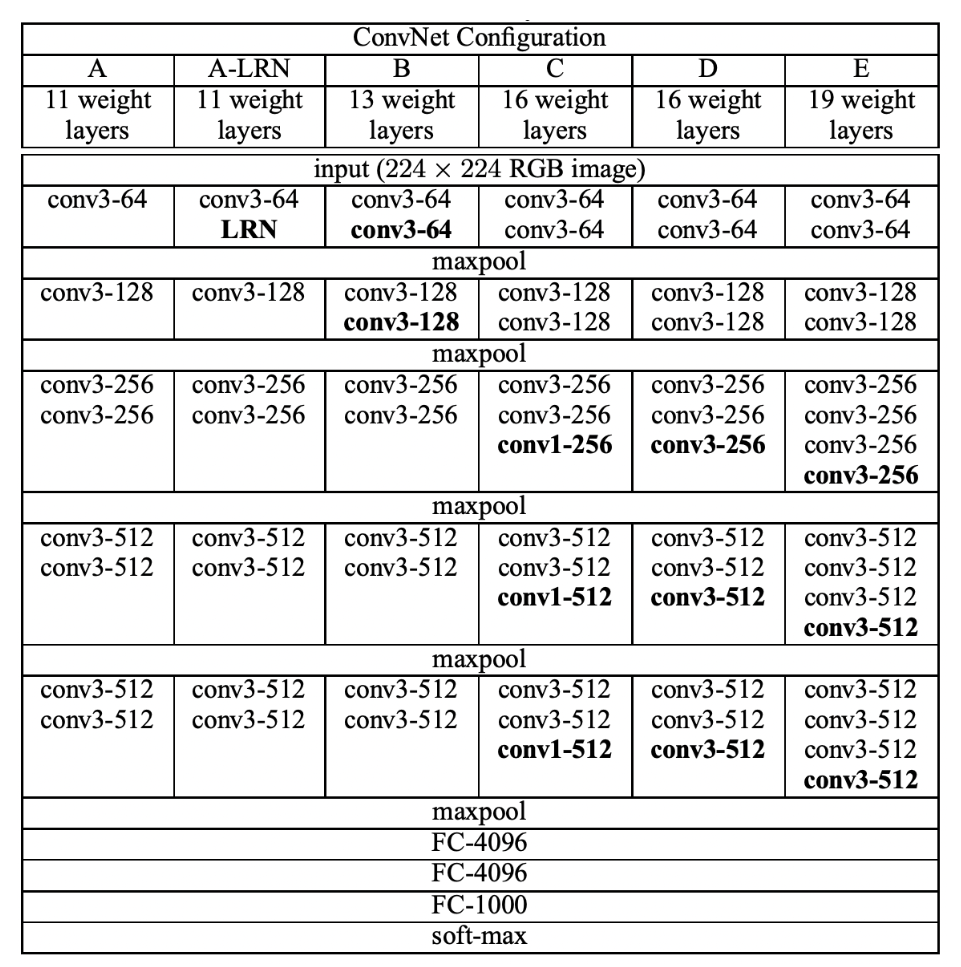

앞에 나온 모델들은 11 x 11이나 7 x 7과 같은 큰 크기를 사용했지만, VGGNet은 최소크기에 가까운 3 x 3 이나 1 x 1을 사용하였다.

3 × 3 크기의 커널을 2번 연속 사용하는 것은 5 × 5 크기의 커널을 사용하는 것과 같고, 3 × 3 커널을 3번 연속 사용하는 것은 7 ×7 크기의 커널을 사용하는 것과 같다고 생각할 수 있다.

큰 커널을 사용하지 않고 작은 커널을 여러개 쌓는 이유는 
- decision function을 더 차별적이게 만든다.
- 파라미터의 수(크기)를 감소시킬 수 있다.

몇 차례의 Conv layer 이후, 맥스풀링은 2x2 stride 2로 5번 들어가 다운 사이즈 한다.

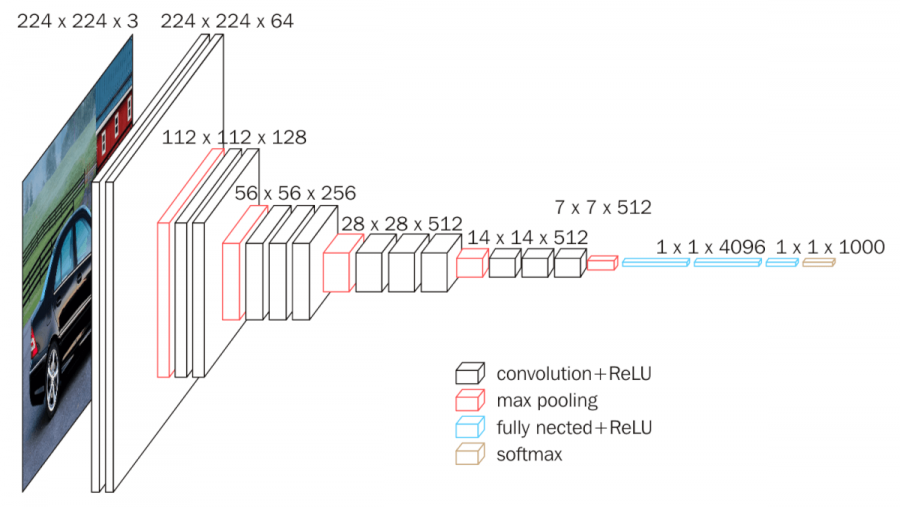

## VGG16

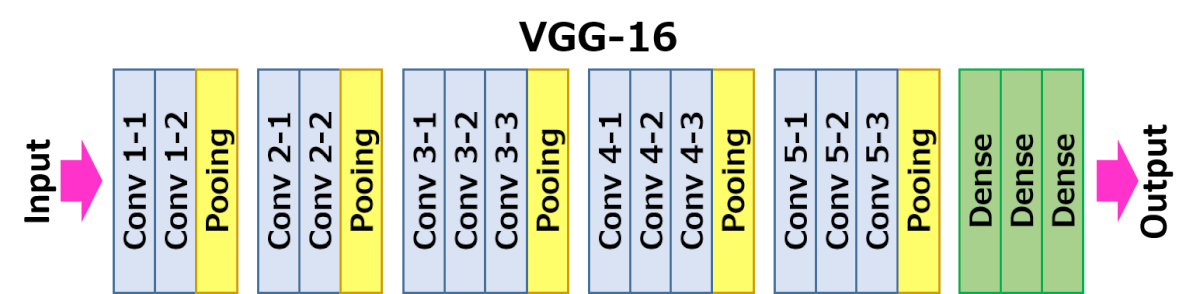

In [2]:
import torch

def conv_2_block(input_dim, output_dim):
    model = torch.nn.Sequential(
        torch.nn.Conv2d(input_dim, output_dim, kernel_size=3, stride = 1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(input_dim, output_dim, kernel_size=3, stride = 1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2)
    )
    return model

In [3]:
def conv_3_block(input_dim, output_dim):
    model = torch.nn.Sequential(
        torch.nn.Conv2d(input_dim, output_dim, kernel_size=3, stride = 1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(input_dim, output_dim, kernel_size=3, stride = 1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(input_dim, output_dim, kernel_size=3, stride = 1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2)
    )
    return model

In [4]:


class VGGNet(torch.nn.Module):
    def __init__(self, num_classes = 10):
        super(VGGNet, self).__init__()
        self.feature = torch.nn.Sequential(
            conv_2_block(3,64), #64
            conv_2_block(64,128), #128
            conv_3_block(128,256), #256
            conv_3_block(256,512), #512
            conv_3_block(512,512), #512        
        )
        self.fc_layer = torch.nn.Sequential(
            # CIFAR10은 크기가 32x32이므로 
            torch.nn.Linear(512*1*1, 4096),
            # IMAGENET이면 224x224이므로
            # nn.Linear(8*base_dim*7*7, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096, 1000),
            torch.nn.ReLU(True),
            torch.nn.Dropout(),
            torch.nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)

        x = x.view(x.size(0), -1)

        x = self.fc_layer(x)
        return x

In [5]:
# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# VGG 클래스를 인스턴스화
model = VGGNet().to(device)

# 손실함수 및 최적화함수 설정
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

cuda:0
